In [10]:
import os
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from ipykernel import kernelapp as app

import tensorflow as tf
import PIL as  pil 
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3 , preprocess_input , decode_predictions
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import *
from keras.optimizers import SGD , Adam
from keras.callbacks import ModelCheckpoint

print(os.listdir("data/stanford-car-dataset-by-classes-folder/car_data/car_data/"))

import seaborn as sns

sns.set_style({'xtick.bottom':False,
               'ytick.left':False,
               'axes.spines.bottom': False,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False})



['test', 'train']


In [11]:
train_img_path = 'data/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
test_img_path = 'data/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

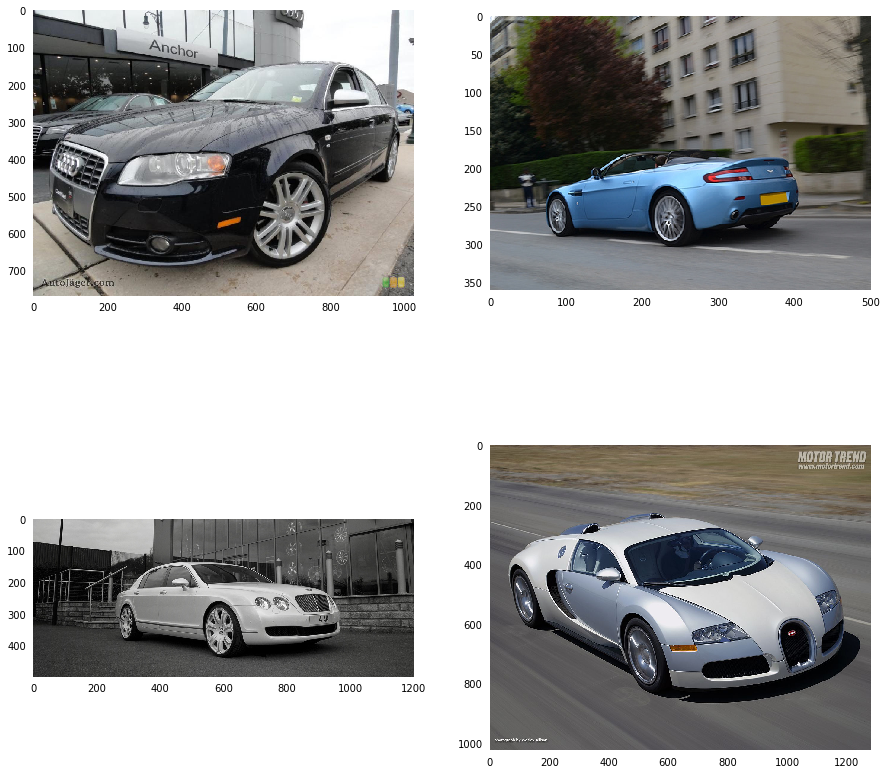

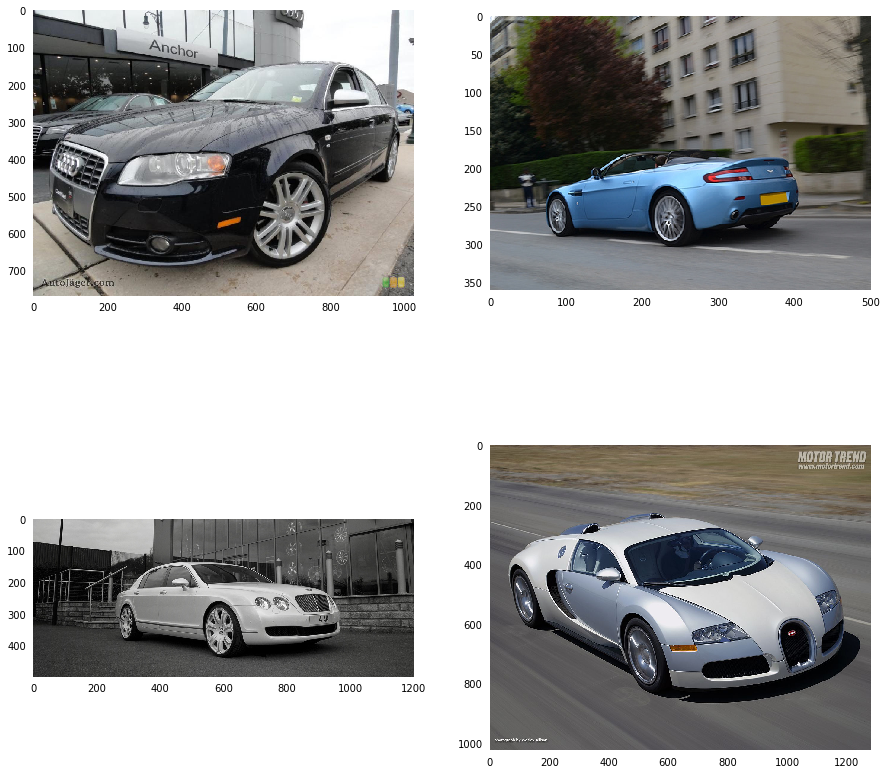

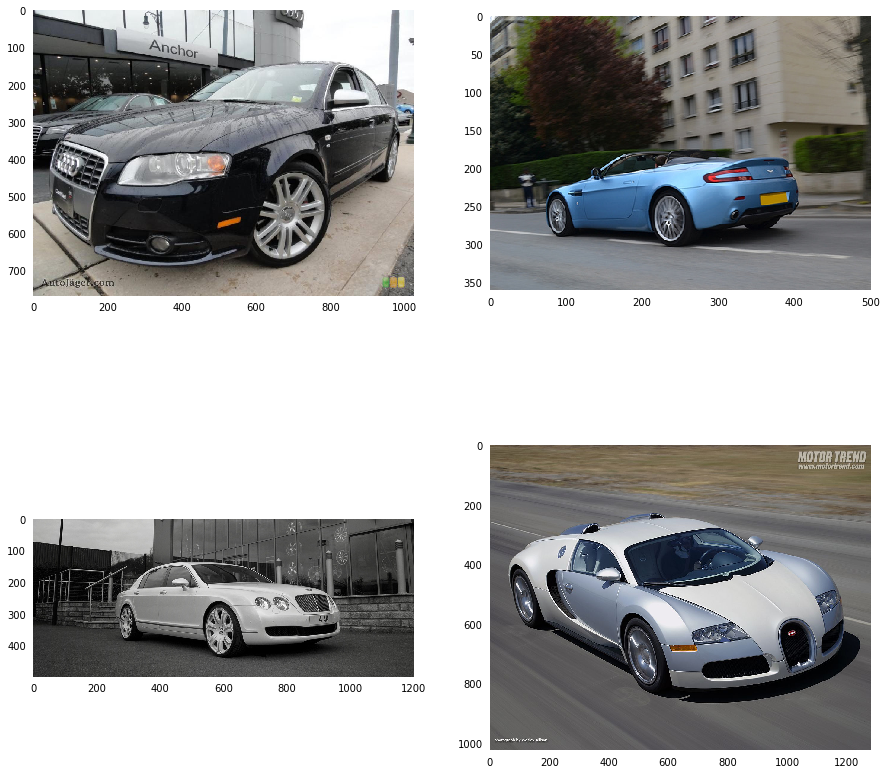

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
img1 = plt.imread("data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi S4 Sedan 2007/00159.jpg")
img2 = plt.imread("data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/00065.jpg")
img3 = plt.imread("data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/00057.jpg")
img4 = plt.imread("data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bugatti Veyron 16.4 Coupe 2009/01249.jpg")

ax = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[1,0]
ax3 = axes[1,1]

ax.imshow(img1)
ax1.imshow(img2)
ax2.imshow(img3)
ax3.imshow(img4)

plt.show()

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# anno_test.csv has 8041 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('data/stanford-cars-dataset/anno_test.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'anno_test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

In [17]:
car_name_train = {}
for i in os.listdir(train_img_path):
    car_name_train[i] =  os.listdir(train_img_path+'/'+i)

In [18]:
car_img_list = []
car_name_list = []
car_classes = []
car_dr = []

In [19]:
for i in car_name_train:
    car_classes.append(i)

In [20]:
for i , j in enumerate(car_name_train.values()):
    for img in j :
        car_img_list.append(img)
        car_name_list.append(car_classes[i])

In [21]:
for i in range(len(car_name_list)):
    car_dr.append(train_img_path+'/'+car_name_list[i]+'/'+car_img_list[i])

In [9]:
height = 299
width = 299

weight_path = 'models/InceptionV3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = InceptionV3(weights = weight_path ,
                      include_top = False,
                     input_shape = (height , width , 3))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        rotation_range = 10, # data augmentation
        horizontal_flip = True,# data augmentation
        vertical_flip = True
        )

train_generator = train_data_generator.flow_from_directory(train_img_path,
                                                          target_size = (height , width), 
                                                          batch_size = 80)

Found 8144 images belonging to 196 classes.


In [16]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
def built_finetune_model(base_model , fc_layers , n_classes):
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    
    for unit in fc_layers:
        x = Dense(units = unit , activation = 'relu')(x)
    
    predictions = Dense(n_classes , activation = 'softmax')(x)
    
    finetune_model = Model(inputs = base_model.input , outputs =  predictions)
    
    return finetune_model
        

In [18]:
n_classes = 196
fc_layers = [1050 , 500]

finetune_model = built_finetune_model(base_model , 
                                     fc_layers , 
                                     n_classes)

In [19]:
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
epochs = 10
batch_size = 80 
num_train_images = 8144

adam = Adam(lr = 0.00001)
finetune_model.compile(adam , loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

filepath = 'Resnet50_weights1.h5'
checkpoint = ModelCheckpoint(filepath , monitor = ['acc'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator , epochs = epochs , 
                                      workers = 8 , steps_per_epoch = num_train_images//batch_size ,
                                      shuffle = True , callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 44/101 [============>.................] - ETA: 49:25 - loss: 5.3693 - acc: 0.0074

KeyboardInterrupt: 